# Modeling

Current score after reshuffling of public/private datasets:
* resnet50 - 224px - 0.2 threshold: 0.348
* resnet50 - 224px - best threshold based on validation set: 0.367

In progress:
* 512px
* [External data](https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/73395)
* Soft labels with test set
* Weighted sampler

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#usual stuff
from tqdm import trange
from collections import Counter, namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import warnings
warnings.filterwarnings("ignore")

#image processing
from scipy import misc

#fastai
import fastai
from fastai import *          # Quick accesss to most common functionality
from fastai.vision import *   # Quick accesss to computer vision functionality

#paths
DATA_PATH = '/home/ubuntu/.kaggle/competitions/human-protein-atlas-image-classification/'

#constants
itol = ['Nucleoplasm', 
        'Nuclear membrane',   
        'Nucleoli',
        'Nucleoli fibrillar center',
        'Nuclear speckles',   
        'Nuclear bodies',   
        'Endoplasmic reticulum',
        'Golgi apparatus',   
        'Peroxisomes',   
        'Endosomes',   
        'Lysosomes',   
        'Intermediate filaments',   
        'Actin filaments',   
        'Focal adhesion sites',   
        'Microtubules',   
        'Microtubule ends',   
        'Cytokinetic bridge',   
        'Mitotic spindle',   
        'Microtubule organizing center',   
        'Centrosome',   
        'Lipid droplets',   
        'Plasma membrane',   
        'Cell junctions',   
        'Mitochondria',   
        'Aggresome',   
        'Cytosol',   
        'Cytoplasmic bodies', 
        'Rods & rings']

#check cuda
print(f'PyTorch version {torch.version.__version__}')
print(f'CUDA is {torch.cuda.is_available()}')
print(f'CuDnn is {torch.backends.cudnn.enabled}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

PyTorch version 1.0.0.dev20180929
CUDA is True
CuDnn is True


device(type='cuda')

## Data Bunch

In [69]:
def open_4c(id):
    if str(id)[-4:]=='.png':
        id = Path(str(id).split('_')[0])
    red_channel = imageio.imread(f'{id}_red.png')
    green_channel = imageio.imread(f'{id}_green.png')
    blue_channel = imageio.imread(f'{id}_blue.png')
    yellow_channel = imageio.imread(f'{id}_yellow.png')
    all_channels = np.stack([red_channel,green_channel,blue_channel,yellow_channel],-1)
    img_tensor = torch.tensor(all_channels, dtype=torch.float).div_(255)
    img_tensor = img_tensor.permute(2,0,1)
    return(Image(img_tensor))

In [70]:
df = pd.read_csv(f'{DATA_PATH}train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [71]:
data_pre = (ImageItemList.from_df(df, DATA_PATH, folder='train', suffix='')
           .random_split_by_pct(0.2)
           .label_from_df(sep=' ',  classes=[str(i) for i in range(28)])
           .add_test_folder('test','0'))

#change image opener
data_pre.train.x.create_func = open_4c
data_pre.train.x.open = open_4c
data_pre.valid.x.create_func = open_4c
data_pre.valid.x.open = open_4c
data_pre.test.x.create_func = open_4c
data_pre.test.x.open = open_4c

In [72]:
#stats from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
#augmentation
tfms_train,tfms_valid = get_transforms(do_flip = True, flip_vert=True, max_rotate = 30,
                      max_lighting=0.05, max_zoom=1.05, max_warp=0.)
data = (data_pre.transform((tfms_train,tfms_valid), size=224)
        .databunch(bs=64, num_workers=4)
        .normalize(protein_stats))

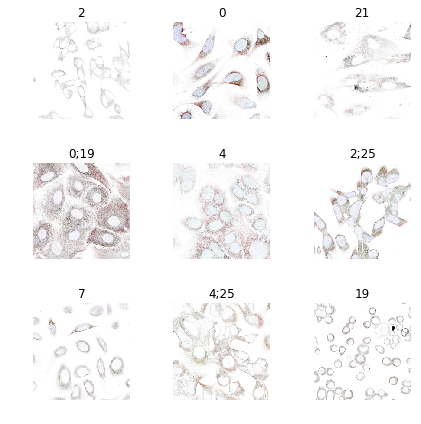

In [73]:
data.show_batch(rows=3, figsize=(6,6))

In [74]:
x = next(iter(data.train_dl))
x[0].shape

torch.Size([64, 4, 224, 224])

## Focal Loss

In [8]:
#stolen from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError(f"Target size ({target.size()}) must be the same as input size ({input.size()})")

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

## Macro F-1

In [9]:
def fbeta_macro(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=1, 
                eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    "Computes the macro f_beta between `y_pred` and `y_true` in a multi-classification task."
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=0)
    prec = TP/(y_pred.sum(dim=0)+eps)
    rec = TP/(y_true.sum(dim=0)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

## Learner

### 4c ResNet-50

In [75]:
learn = create_cnn(data = data, arch = models.resnet50, ps = 0.5, 
                   callback_fns=[ShowGraph,partial(GradientClipping, clip=1.)])

In [76]:
learn.opt_func = partial(optim.Adam, betas=(0.9, 0.99))
# learn.loss_func = FocalLoss(gamma = 2)
learn.loss_func = F.binary_cross_entropy_with_logits
fbeta_micro = partial(fbeta, thresh=0.2, beta=1)
learn.metrics = [fbeta_macro,fbeta_micro]
learn.freeze()

In [77]:
#choices of architecture
# #adding a 4-to-3 conv layer
# four_to_three = nn.Conv2d(4, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
# learn.model = nn.Sequential(four_to_three,learn.model)

#customize first layer for 4 channels
w = learn.model[0][0].weight
learn.model[0][0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
# insert_w = torch.randn(64,1,7,7).to(device) #random initialization
insert_w = w.mean(1).unsqueeze(1) #mean initialization
learn.model[0][0].weight = torch.nn.Parameter(torch.cat((w,insert_w),dim=1))
#unfreeze it
# learn.model[0][0].weight.requires_grad = True

#train frozen
learn.freeze()

In [78]:
# learn.lr_find()
# learn.recorder.plot()

In [79]:
lrs = learn.lr_range(slice(3e-2))
lrs

array([0.003, 0.003, 0.03 ])

epoch,train_loss,valid_loss,fbeta_macro,fbeta
1,0.144959,0.134412,0.208173,0.502181
2,0.134719,0.132900,0.225061,0.534715
3,0.125775,0.149996,0.283526,0.583437
4,0.112175,0.129897,0.322889,0.633196
5,0.107493,0.108034,0.327298,0.641473


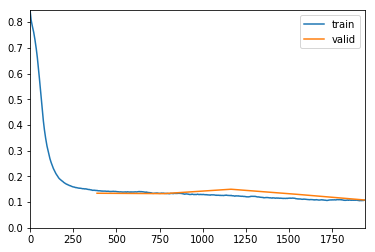

In [14]:
learn.fit_one_cycle(cyc_len = 5,
                    max_lr= lrs, #discriminative learning rates
                    moms = (0.95,0.85), #momentums
                    div_factor = 25, #factor to discount from max
                    pct_start = 0.3, #where the peak is at 
                   ) 

In [15]:
#save
# learn.save('resnet50-frozen')

In [15]:
#load
learn.load('resnet50-frozen')
#train all layers
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


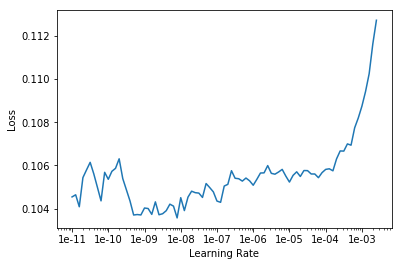

In [25]:
learn.lr_find(start_lr = 1e-12, end_lr =1e-2)
learn.recorder.plot()

In [16]:
lrs = learn.lr_range(slice(3e-4))
lrs

array([3.e-05, 3.e-05, 3.e-04])

epoch,train_loss,valid_loss,fbeta_macro,fbeta
1,0.106713,0.112118,0.339588,0.653976
2,0.106646,0.103570,0.340491,0.655649
3,0.105877,0.103930,0.343553,0.651825
4,0.102109,0.144360,0.347664,0.662366
5,0.097945,0.105316,0.357727,0.668019
6,0.096587,0.253260,0.365197,0.671797
7,0.094498,0.109420,0.369844,0.678288
8,0.091175,0.104209,0.378366,0.686778
9,0.089026,0.100350,0.381622,0.686811
10,0.089178,0.135260,0.386414,0.689632


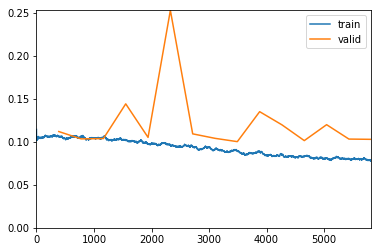

In [17]:
learn.fit_one_cycle(cyc_len = 15, 
                    max_lr= lrs, #discriminative learning rates
                    moms = (0.95,0.85), #momentums
                    div_factor = 25, #factor to discount from max
                    pct_start = 0.3, #where the peak is at 
                   ) 

In [18]:
#save
# learn.save('resnet50-unfrozen')

In [23]:
preds,y,loss = learn.TTA(ds_type=DatasetType.Valid, with_loss=True)

In [26]:
#TTA without threshold optimization
fbeta_macro(preds, y, sigmoid=False)

tensor(0.4981)

## Threshold Optimization

In [81]:
learn.load('resnet50-unfrozen')
print('model loaded')

model loaded


In [82]:
def single_macro_fbeta(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, 
             beta:float=1, eps:float=1e-9) -> Rank0Tensor:
    "Computes the macro averaged f_beta between preds and targets for binary tensors"
    
    beta2 = beta**2
    pred_i = (y_pred>thresh).float()
    true_i = y_true.float()

    tp = (pred_i*true_i).sum()
    prec = tp/(pred_i.sum()+eps)
    rec = tp/(true_i.sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return(res.mean())

def best_thresh(y_pred:Tensor, y_true:Tensor, eval_func = single_macro_fbeta,
                precision = 10000):
    
    "Computes the best threshold for macro averaged f_beta between preds and targets  for binary tensors"
    
    thresh = []
    result = []
    for i in range(precision):
        thresh.append(i/precision)
        result.append(eval_func(y_pred,y_true,thresh=i/precision))
    idx = np.argmax(result)
    return(thresh[idx])

In [30]:
best_threshes = []
for i in trange(len(data.train_ds.y.classes)):
    best_threshes.append(best_thresh(preds[:,i],y[:,i]))

100%|██████████| 28/28 [01:00<00:00,  2.14s/it]


In [31]:
best_threshes[:10]

[0.3925, 0.168, 0.4486, 0.2894, 0.5878, 0.2604, 0.2182, 0.2776, 0.0678, 0.1101]

In [32]:
def fbeta_macro_thresh(y_pred:Tensor, y_true:Tensor, threshes:List=[], 
             beta:float=1, eps:float=1e-9) -> Rank0Tensor:
    "Computes the macro averaged f_beta between preds and targets with optimal thresholds"
    
    beta2 = beta**2
    y_true = y_true.float()
    nb_sample,nb_class = y_true.shape

    reses = []
    for i in range(nb_class):
        pred_i = y_pred[:,i]
        pred_i = (pred_i > threshes[i]).float()
        true_i = y_true[:,i]
        tp = (pred_i*true_i).sum()
        prec = tp/(pred_i.sum()+eps)
        rec = tp/(true_i.sum()+eps)
        res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
        reses.append(res)
    return(torch.tensor(reses).mean())

In [83]:
fbeta_macro_thresh(preds,y,best_threshes)

tensor(0.5676)

## Test Submission

In [84]:
preds,y,loss = learn.TTA(ds_type=DatasetType.Test, with_loss=True)

In [146]:
def pred_thresh(y_pred:Tensor, threshes:List=[]) -> Rank0Tensor:
    "Computes the macro averaged f_beta between preds and targets"
    
    beta2 = beta**2
    y_true = y_true.float()
    nb_sample,nb_class = y_true.shape

    reses = []
    for i in range(nb_class):
        pred_i = y_pred[:,i]
        pred_i = (pred_i > threshes[i]).float()
        true_i = y_true[:,i]
        tp = (pred_i*true_i).sum()
        prec = tp/(pred_i.sum()+eps)
        rec = tp/(true_i.sum()+eps)
        res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
        reses.append(res)
    return(torch.tensor(reses).mean())

In [147]:
test_ids = [str(i).split('/')[-1].split('.')[0] for i in data.test_ds.items]
test_df = pd.DataFrame({'Id':test_ids, 'Predicted':''})
test_df.head()

,Id,Predicted
0,141d4244-bad5-11e8-b2b8-ac1f6b6435d0_blue,
1,9f039c1e-bada-11e8-b2b9-ac1f6b6435d0_yellow,
2,a7f2cb7e-bacb-11e8-b2b8-ac1f6b6435d0_red,
3,9e78e720-bad2-11e8-b2b8-ac1f6b6435d0_green,
4,b04d6e12-bad7-11e8-b2b9-ac1f6b6435d0_blue,


In [148]:
for i in range(len(data.test_ds.y.classes)):
    #thresholding 0.36
    test_df[data.test_ds.y.classes[i]] = (preds[:,i] > best_threshes[i])
    #w/o thresholding 0.34
#     test_df[data.test_ds.y.classes[i]] = (preds[:,i] > 0.2)
test_df['Id'] = test_df['Id'].apply(lambda x: x.split('_')[0])
test_df = test_df.groupby('Id').max()
test_df.reset_index(inplace=True)

In [149]:
test_df.head()

,Id,Predicted,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [150]:
for i in range(test_df.shape[0]):
    row = test_df.iloc[i,:]
    predicted = []
    for j in test_df.columns[2:]:
        if row[j] == 1:
            predicted.append(j)
    predicted_str = ' '.join(predicted)
    test_df.iloc[i,1] = predicted_str

In [151]:
submit = test_df.iloc[:,:2]
submit.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 23 25


In [152]:
sample_df = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
sample_df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [153]:
sample_submit = sample_df.merge(submit, on='Id')
sample_submit = sample_submit[['Id','Predicted_y']]
sample_submit.columns = ['Id','Predicted']

In [154]:
sample_submit.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 23 25


In [156]:
sample_submit.to_csv(f'{DATA_PATH}resnet50_baseline.csv', index= False)

## To-dos

* External Data
* Training on Test Set
* Weighted Sampler